## Prepare

In [1]:
# Environment, data and plotting preparation.
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
db = load_iris()
X_total, y_total = db['data'], db['target']

In [5]:
print(X_total.shape)
print(y_total.shape)

(150, 4)
(150,)


In [ ]:
# take only two classes 0. setosa, 1. versicolor and 2. virginica
c0 = 0
c1 = 1
sub_index = np.logical_or(y_total == c0, y_total == c1)
X = X_total[sub_index]
y = y_total[sub_index]
y[y==c0] = 0
y[y==c1] = 1

X = X[:, [0, 1]]

# Specify the feature_range as a tuple
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [2]:
# split the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

# Plotting setup
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
grid_X = np.stack([xx.flatten(), yy.flatten()]).T

def draw_landscape(pred_fn, steps=0):
    Z = pred_fn(grid_X).reshape(xx.shape)
    cmap = 'viridis'
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap, vmin=-1, vmax=1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap,s=30, edgecolor='k', vmin=-1, vmax=1)
    plt.savefig(f"Step{steps:04d}-a.png")
    return plt.gcf()

## Demo of Backprop Algorithm and Training

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class NeuralNet:
    def __init__(self):
        rng = np.random.RandomState(42)
        self.W = rng.randn(2, 4) * 0.1
        self.B1 = np.zeros(4)
        self.U = rng.randn(4, 1) * 0.1
        self.B2 = np.zeros(1)

    def forward(self, X):
        self.X = X
        self.A = np.dot(X, self.W) + self.B1
        self.H = sigmoid(self.A)
        self.B = np.dot(self.H, self.U) + self.B2
        self.P = sigmoid(self.B)
        return self.P.squeeze()

    def backward(self, dP):
        dB = (1 - self.P) * self.P * dP
        dB2 = np.sum(dB, axis=0)
        dU = np.dot(self.H.T, dB)
        dH = np.dot(dB, self.U.T)
        dA = (1 - self.H) * self.H * dH
        dB1 = np.sum(dA, axis=0)
        dW = np.dot(self.X.T, dA)
        self.dU = dU
        self.dW = dW
        self.dB1 = dB1
        self.dB2 = dB2


def loss(pred, y):
    # neg log likelihood
    return - (y * np.log(pred) + (1 - y) * np.log(1 - pred)).mean()

def dloss(pred, y):
    # grad w.r.t. pred
    return - (y / pred - (1 - y) / (1 - pred)) / pred.size

def dloss_num(pred, y):
    eps = 1e-6
    n = pred.size
    loss0 = loss(pred, y)
    grad_num = np.zeros_like(pred)
    for i in range(n):
        p0 = pred[i]
        pred[i] += eps
        dl = loss(pred, y) - loss0
        grad_num[i] = dl / eps
        pred[i] = p0
    return grad_num

def dW_num(nn, X, y):
    eps = 1e-6
    loss0 = loss(nn.forward(X), y)
    grad_num = np.zeros_like(nn.W)

    for i in range(nn.W.shape[0]):
        for j in range(nn.W.shape[1]):
            w0 = nn.W[i, j]
            nn.W[i, j] += eps
            dl = loss(nn.forward(X), y) - loss0
            grad_num[i, j] = dl / eps
            nn.W[i, j] = w0
    return grad_num

def dU_num(nn, X, y):
    eps = 1e-6
    loss0 = loss(nn.forward(X), y)
    grad_num = np.zeros_like(nn.U)

    for i in range(nn.U.shape[0]):
        for j in range(nn.U.shape[1]):
            u0 = nn.U[i, j]
            nn.U[i, j] += eps
            dl = loss(nn.forward(X), y) - loss0
            grad_num[i, j] = dl / eps
            nn.U[i, j] = u0
    return grad_num

def dB1_num(nn, X, y):
    eps = 1e-6
    loss0 = loss(nn.forward(X), y)
    grad_num = np.zeros_like(nn.B1)

    for i in range(nn.B1.size):
        b0 = nn.B1[i]
        nn.B1[i] += eps
        dl = loss(nn.forward(X), y) - loss0
        grad_num[i] = dl / eps
        nn.B1[i] = b0
    return grad_num

def dB2_num(nn, X, y):
    eps = 1e-6
    loss0 = loss(nn.forward(X), y)
    grad_num = np.zeros_like(nn.B2)

    for i in range(nn.B2.size):
        b0 = nn.B2[i]
        nn.B2[i] += eps
        dl = loss(nn.forward(X), y) - loss0
        grad_num[i] = dl / eps
        nn.B2[i] = b0
    return grad_num

In [4]:
# Test forward computation and derivative of Loss / network output
nn = NeuralNet()
pred = nn.forward(X_train)
print(pred[:5], y_train[:5])
print(loss(pred, y_train))
print(dloss(pred, y_train))
print(dloss_num(pred, y_train))

[0.48934825 0.48973772 0.48881686 0.4897343  0.48956847] [0 1 0 1 1]
0.6934179953399257
[ 0.02797545 -0.02917013  0.02794637 -0.02917034 -0.02918022 -0.02918891
 -0.02919112 -0.02920588 -0.02917458  0.02800758  0.0279749  -0.02916671
  0.02798529 -0.02916268  0.02800424 -0.02921316  0.02799495 -0.02917739
  0.02794267 -0.02921336  0.02795914  0.02798826 -0.02922348  0.02800758
  0.02800163 -0.02915221  0.02800442  0.0279723  -0.02919577  0.02798511
  0.02793345 -0.02917719  0.02795228  0.02802428  0.02799531  0.02796544
 -0.02922044 -0.0291988  -0.02918405  0.0280111   0.02798511  0.02800108
  0.02797842 -0.02923824  0.02798826  0.02796878 -0.0291984  -0.02914178
 -0.02918426  0.02798492  0.0280046  -0.02918446 -0.02918426  0.02799142
 -0.02918184 -0.02916329  0.0279684  -0.0291986  -0.02918769  0.02800089
  0.0279723   0.02795951 -0.0291988   0.02800795 -0.02923096 -0.02914157
 -0.02919173  0.02798176 -0.02918103 -0.02918749]
[ 0.02797548 -0.0291701   0.0279464  -0.02917031 -0.0291801

In [5]:
# Test the backprop computation
nn = NeuralNet()
pred = nn.forward(X)
dpred = dloss(pred, y)[:, np.newaxis]
nn.backward(dpred)
dW = nn.dW
dU = nn.dU
dB1 = nn.dB1
dB2 = nn.dB2
dWn = dW_num(nn, X, y)
dUn = dU_num(nn, X, y)
dB1n = dB1_num(nn, X, y)
dB2n = dB2_num(nn, X, y)
print("==check dW==")
print(dW)
print(dWn-dW)
print("==check dU==")
print(dU)
print(dUn-dU)
print("==check dW==")
print(dB1)
print(dB1n-dB1)
print("==check dW==")
print(dB2)
print(dB2n-dB2)

==check dW==
[[ 0.00200615 -0.00231918  0.00198006  0.00198635]
 [-0.00161819  0.0018703  -0.00159455 -0.00160448]]
[[ 7.15358051e-11 -8.94564292e-11 -8.50649152e-11 -2.44893039e-10]
 [-1.38132335e-11 -1.04983183e-10 -2.30421599e-10 -6.35029399e-11]]
==check dU==
[[-0.00819615]
 [-0.0054821 ]
 [-0.00259354]
 [-0.00912641]]
[[3.09090573e-08]
 [3.11431216e-08]
 [3.05839029e-08]
 [3.02063847e-08]]
==check dW==
[ 0.00012377 -0.00014284  0.000121    0.00012387]
[-1.43533340e-10 -1.51505642e-12 -1.05969078e-10 -2.08165388e-10]
==check dW==
[-0.01053196]
[1.2484828e-07]


0 0.6935575396950275
100 0.6927265255701199
200 0.6916021483483386
300 0.6884538130527343
400 0.6793680518938758
500 0.6544596011636387
600 0.5955183832118288
700 0.49219481302833445
800 0.372366514246618
900 0.2742945509601903
1000 0.20663051988785638
1100 0.1616423054970662
1200 0.1311087311225859
1300 0.1096069621343797
1400 0.09388403067912453
1500 0.08199141090622007
1600 0.07273039795586021
1700 0.06533815932186242
1800 0.059312517269087914
1900 0.054312314891587915
2000 0.05009909829426143
2100 0.046501903001400106
2200 0.04339533824948236
2300 0.040685556378906994
2400 0.03830103386759305
2500 0.036186368416468995
2600 0.034298014035468415
2700 0.032601290122231286
2800 0.031068245740361745
2900 0.029676109117867697
3000 0.028406144770050757
3100 0.027242799222159088
3200 0.026173054171936556
3300 0.025185930857549246
3400 0.024272106082085805
3500 0.02342361169194402
3600 0.022633597135265932
3700 0.021896140202902325
3800 0.021206094934543354
3900 0.020558968455175814
4000 0.

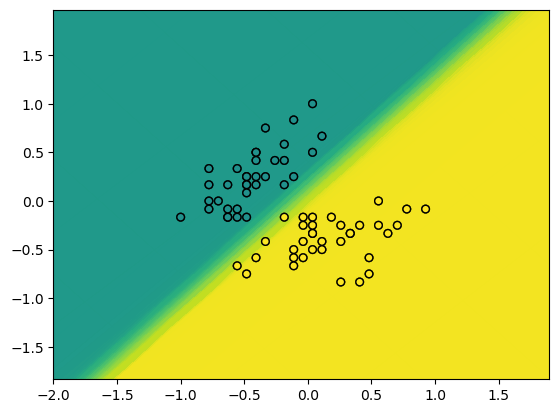

In [6]:
# optimisation steps to fit the model parameters to the data
nn = NeuralNet()
learning_rate = 0.1

iter_counter = 0
MAX_ITER = 5000
while True:
    pred = nn.forward(X)
    loss_value = loss(pred, y)
    dpred = dloss(pred, y)[:, np.newaxis]
    nn.backward(dpred)

    nn.W -= nn.dW * learning_rate
    nn.U -= nn.dU * learning_rate
    nn.B1 -= nn.dB1 * learning_rate
    nn.B2 -= nn.dB2 * learning_rate


    if iter_counter % 100 == 0:
        print(iter_counter, loss_value)

    if iter_counter % 500 == 0:
        draw_landscape(nn.forward, iter_counter)


    iter_counter += 1

    if iter_counter >= MAX_ITER:
        break

## Demo of approximation (fit to the data)

In [7]:
from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(hidden_layer_sizes=(8,), max_iter=1000)
mlp2 = MLPClassifier(hidden_layer_sizes=(2000,), max_iter=10000)

In [8]:
mlp1 = mlp1.fit(X_train, y_train)
mlp2 = mlp2.fit(X_train, y_train)

c:\Users\talha\miniconda3\envs\test1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\talha\AppData\Local\Temp\ipykernel_11480\3233778510.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


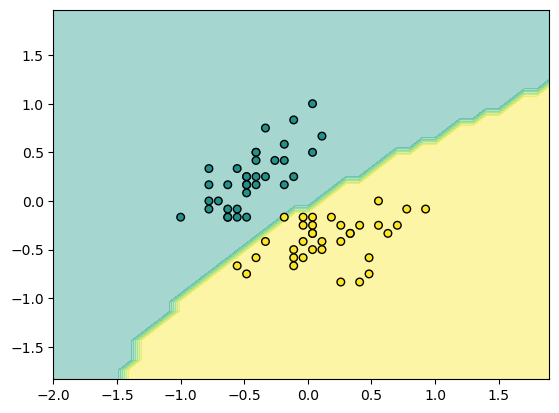

In [9]:
fig1 = draw_landscape(mlp1.predict)
fig1.show()

C:\Users\talha\AppData\Local\Temp\ipykernel_11480\1928792271.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


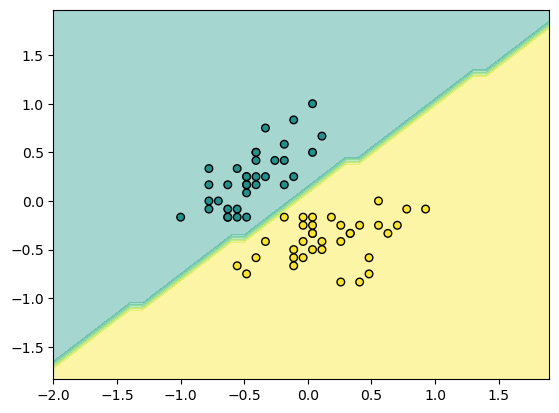

In [10]:
fig2 = draw_landscape(mlp2.predict)
fig2.show()

With some noises

In [11]:
y_train0 = y_train.copy()
# randomly flip some labels
y_train = y_train0
rng = np.random.RandomState(42)
for i, y in enumerate(y_train):
    if rng.rand() < 0.5:
        y_train[i] = 1 - y

In [12]:
mlp1 = MLPClassifier(hidden_layer_sizes=(8,), max_iter=1000)
mlp2 = MLPClassifier(hidden_layer_sizes=(2000,), max_iter=10000)
mlp1 = mlp1.fit(X_train, y_train)
mlp2 = mlp2.fit(X_train, y_train)

C:\Users\talha\AppData\Local\Temp\ipykernel_11480\3233778510.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


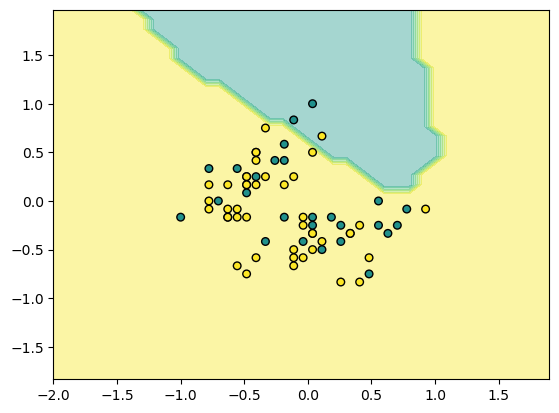

In [13]:
fig1 = draw_landscape(mlp1.predict)
fig1.show()

C:\Users\talha\AppData\Local\Temp\ipykernel_11480\1928792271.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


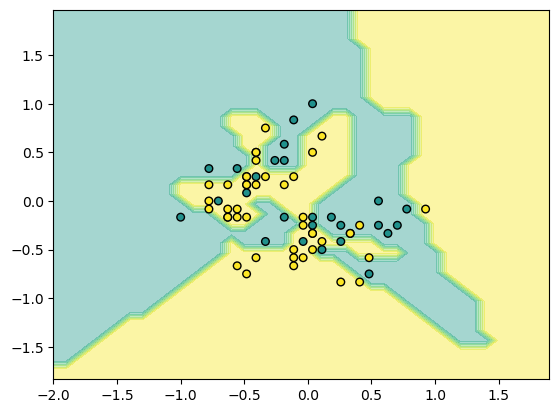

In [14]:
fig2 = draw_landscape(mlp2.predict)
fig2.show()